In [9]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
from PIL import Image
import nibabel as nb

In [10]:
import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy as numpy_projector
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan

In [11]:
# load a sample CT image
# filename = '/workspace/CTProjector/data/example_CT_volume/3.nii.gz'
filename = '/workspace/Documents/data/CT_motion/CT_images/example_CT_volume/patient_3/original/3.nii.gz'
ct = nb.load(filename)
img = ct.get_fdata()
spacing = ct.header.get_zooms()

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = np.rollaxis(img,-1,0)
img = img[np.newaxis, ...]
# img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])
print(img.shape)
print(spacing)

(1, 418, 630, 630)
[1.       0.683594 0.683594]


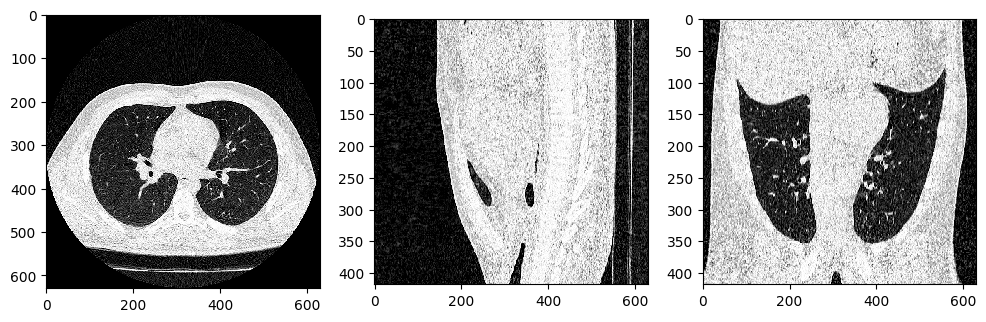

In [12]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...].T, 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [25]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = 1
projector.nv = 1
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]
projector.nview = 768

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 768
rotview = 720
nu = 736
nv = 1
nx = 630
ny = 630
nz = 1
dx = 0.683594
dy = 0.683594
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x7fa72e608dc0>


In [29]:
# very important: make sure that the arrays are saved in C order
cp.cuda.Device(0).use()
ct_projector.set_device(0)

# angles = projector.get_angles()
angles = get_angles_zc(projector.nview, 360,0)
print(angles.shape,angles)
# origin_img = img[0, [img.shape[1]//3, img.shape[1]//2, img.shape[1]//3*2], ...]
origin_img = img[0, 200:264, ...]
origin_img = origin_img[:, np.newaxis, ...]
print(origin_img.shape)
cuimg = cp.array(origin_img, cp.float32, order = 'C')
cuangles = cp.array(angles, cp.float32, order = 'C')

projector.set_projector(ct_fan.distance_driven_fp, angles=cuangles, branchless=True)

(768,) [0.         0.00022726 0.00045451 0.00068177 0.00090903 0.00113628
 0.00136354 0.00159079 0.00181805 0.00204531 0.00227256 0.00249982
 0.00272708 0.00295433 0.00318159 0.00340885 0.0036361  0.00386336
 0.00409062 0.00431787 0.00454513 0.00477238 0.00499964 0.0052269
 0.00545415 0.00568141 0.00590867 0.00613592 0.00636318 0.00659044
 0.00681769 0.00704495 0.0072722  0.00749946 0.00772672 0.00795397
 0.00818123 0.00840849 0.00863574 0.008863   0.00909026 0.00931751
 0.00954477 0.00977203 0.00999928 0.01022654 0.01045379 0.01068105
 0.01090831 0.01113556 0.01136282 0.01159008 0.01181733 0.01204459
 0.01227185 0.0124991  0.01272636 0.01295362 0.01318087 0.01340813
 0.01363538 0.01386264 0.0140899  0.01431715 0.01454441 0.01477167
 0.01499892 0.01522618 0.01545344 0.01568069 0.01590795 0.0161352
 0.01636246 0.01658972 0.01681697 0.01704423 0.01727149 0.01749874
 0.017726   0.01795326 0.01818051 0.01840777 0.01863503 0.01886228
 0.01908954 0.01931679 0.01954405 0.01977131 0.01999856 0

In [31]:
# set which device to use
numpy_projector.set_device(0)
# forward projection
start = time.time()
cufp = projector.fp(cuimg, angles = cuangles)
end = time.time()
print (end - start)

0.5193088054656982


(64, 768, 1, 736)


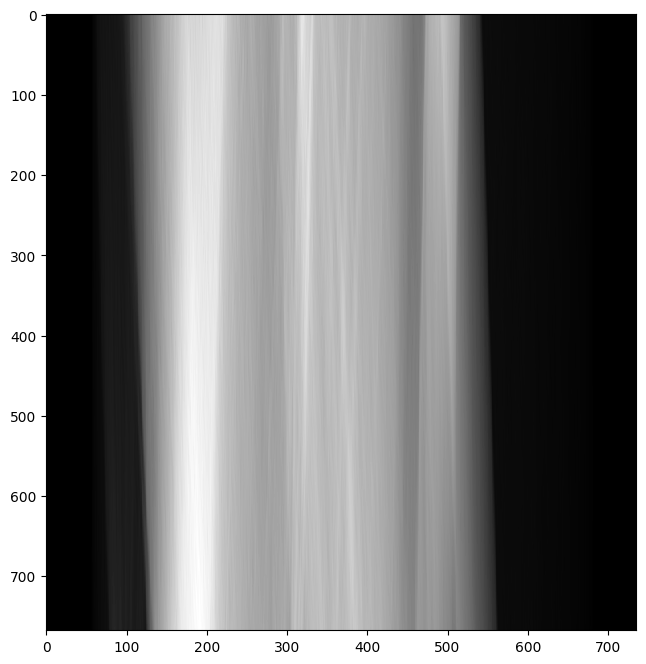

In [32]:
# show the projections
fp = cufp.get()
print(fp.shape)
plt.figure(figsize = (8,8))
a = fp[1,:, 0, :]
plt.imshow(a, 'gray')
# I = np.zeros([a.shape[0],a.shape[1],3])
# # normalize
# a = (a-np.min(a)) / (np.max(a) - np.min(a))

# for i in range(0,3):
#     I[:,:,i] = a
    
# Image.fromarray((I*255).astype('uint8')).save('./projection.png')

In [13]:
fbp_projector = numpy_projector.ct_projector()
fbp_projector.from_file('./projector_fan.cfg')
fbp_projector.nx = img.shape[3]
fbp_projector.ny = img.shape[2]
fbp_projector.nz = 1
fbp_projector.nv = 1
fbp_projector.dx = spacing[2]
fbp_projector.dy = spacing[1]
fbp_projector.dz = spacing[0]

In [21]:
fprj = numpy_fan.ramp_filter(fbp_projector, fp, filter_type='RL')
recon = numpy_fan.fbp_bp(fbp_projector, fprj, angles)

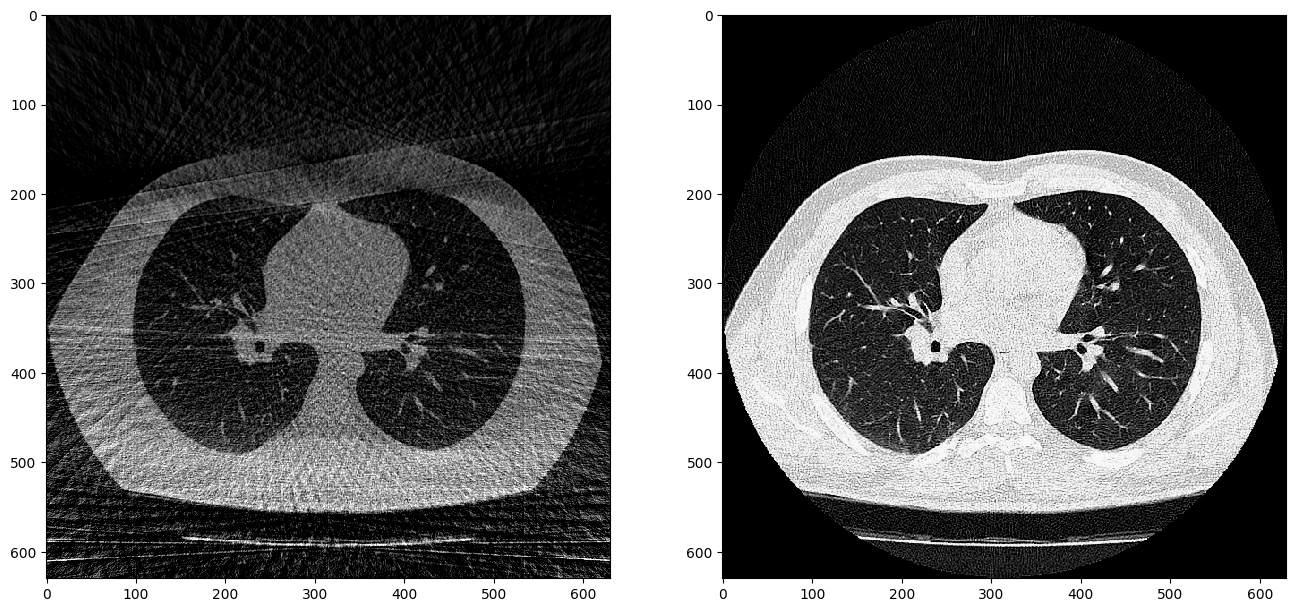

In [22]:
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(recon[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)

In [21]:
projector.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp=True)
cufprj = cp.array(fprj, cp.float32, order = 'C')
curecon = projector.bp(cufprj)

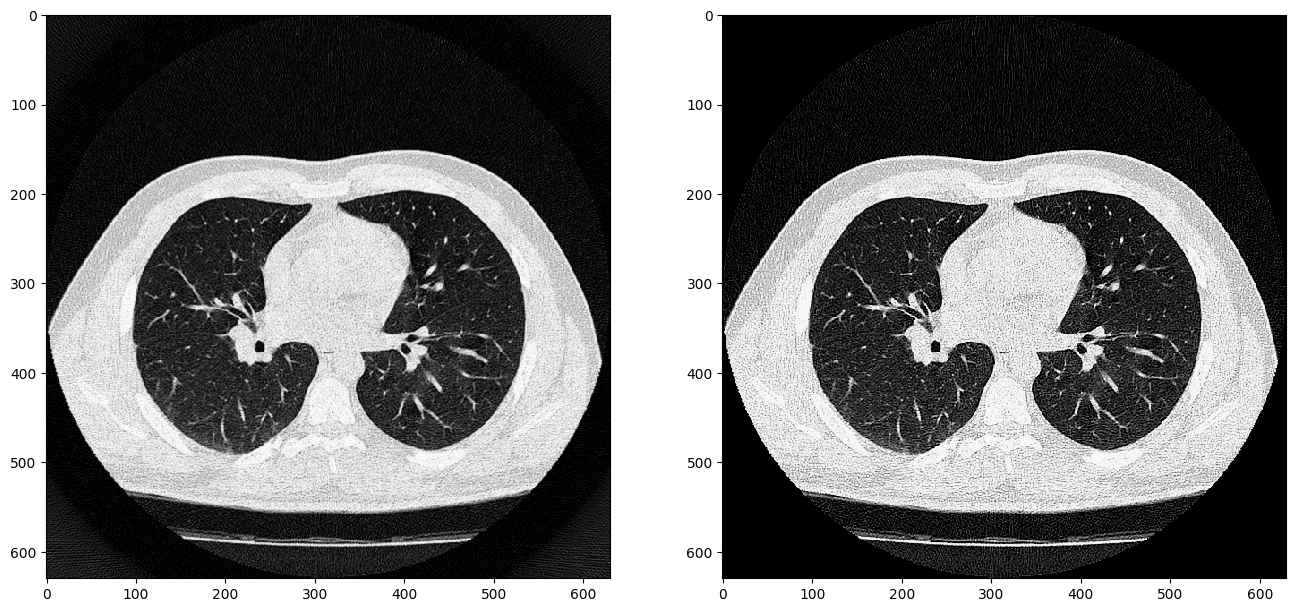

In [22]:
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(curecon.get()[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)